<div class="alert alert-block alert-success">
    <h1>
        Example notebook - CiteAb antibody data
    </h1>
    <h4>
        In this notebook, we will explore how the CiteAb database of antibodies can be used with TuringDB graph database engine.<br><br>
        We will show how to go from CiteAb data in csv format to a TuringDB graph, then querying the newly created graph.
    </h4>
    <p>
        For 14 years, CiteAb has mined over 40M publications, and partnered with 650 of the world's leading reagent manufacturers to bring a centralised, searchable, database of research reagents and experimental models. This includes; antibodies, proteins, small molecules, cell lines amongst several other product categories.

It is designed to enable researchers to dramatically decrease the amount of time it takes to develop new in-vitro assays by providing  published assay data to the products, allowing researchers to make more informed decisions prior to purchasing. This saves both time and resource, on what might have been unsuitable antibodies (for example).

Each reagent is labelled with universal ID numbers (UNIPROT, ChemID, GeneID, PubMedID...) to enable simple integration within your existing knowledge graph - turning a biological knowledge graph into an experimental knowledge graph by linking targets and diseases to the real-world reagents and evidence used to study them.

Check out CiteAb to learn more: <a href="https://www.citeab.com/">CiteAb website</a>

About the sample dataset copyrights and all rights reserved to CiteAb Ltd.
    </p>
</div>

# Import modules and functions

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time
from tqdm.auto import tqdm

from turingdb_examples.graph import (
    build_create_command_from_networkx,
    split_cypher_commands
)

In [2]:
%load_ext autoreload
%autoreload 2

# Check data files are available

In [3]:
example_name = "citeab_antibody"
path_data = f"{os.getcwd()}/data/{example_name}"
if not os.path.exists(path_data):
    raise ValueError(f"{path_data} does not exists")

filename = "CiteAb_HER2_p53_Sample_Antibody_Citations_Aug2025.xlsx"
list_csv_files = sorted(os.listdir(path_data))
if filename not in list_csv_files:
    raise ValueError(
        f"{filename} csv file is not available in {path_data}"
    )

# Import and format data

In [4]:
df = pd.read_excel(f"{path_data}/{filename}")

# Drop rows only containing NaN values
old_shape = len(df)
df = df.dropna(axis=0, how="all")
print(f"Dropped {old_shape - len(df)} rows only containing NaN values")

# Drop columns only containing NaN values
old_shape = df.shape[1]
df = df.dropna(axis=1, how="all")
print(f"Dropped {old_shape - df.shape[1]} columns only containing NaN values")

# Remove rows with NaN values in "citeabid" and "protein_code" columns, and "protein_code" being "not_applicable"
old_shape = df.shape[1]
df = df[df["citeabid"].notna() & df["protein_code"].notna() & (df["protein_code"] != "not_applicable")]
print(f"Dropped {old_shape - df.shape[1]} columns containing NaN values in 'citeabid' and 'protein_code' columns")

# Remove columns only containing "not_applicable"
old_shape = df.shape[1]
df = df.drop(list((df != "not_applicable").sum()[(df != "not_applicable").sum() == 0].index), axis=1)
print(f"Dropped {old_shape - df.shape[1]} columns only containing 'not_applicable'")

df

Dropped 0 rows only containing NaN values
Dropped 4 columns only containing NaN values
Dropped 0 columns containing NaN values in 'citeabid' and 'protein_code' columns
Dropped 3 columns only containing 'not_applicable'


,citeabid,name,code,company,discontinued,host,clonality,clone,conjugate,protein_code,...,published_date,author_list,last_author,citation_applications,citation_reactants,citation_reactant_ncbi_ids,unique_flow_conjugates_count,instruments,ncbi_gene_id,gene_name
0,2390688,c-erbB-2 Oncoprotein,A0485,Dako,Discontinued,Rabbit,Polyclonal,not_applicable,Unconjugated,P04626,...,2018-08-13,"Atif Ali Hashmi, Raeesa Mahboob, Saadia Mehmoo...",Muhammad Muzzammil Edhi,IHC,Homo sapiens (Human),9606,NaN,NaN,2064,ERBB2
1,1026763,HER2/ErbB2 Rabbit pAb,A2071,ABclonal,NaN,Rabbit,Polyclonal,not_applicable,NaN,P04626,...,2020-05-05,"Chongshu Jian, Jiajun Fu, Xu Cheng, Li-jun She...",Hongliang Li,WB,Mus musculus (Mouse),10090,NaN,NaN,2064,ERBB2
2,818617,Neu Antibody (C-18),sc-284,Santa Cruz Biotechnology,Discontinued,Rabbit,Polyclonal,not_applicable,NaN,P04626,...,2011-04-01,"Radwan N Safa, Xu-Yang Peng, Laura Pentassugli...",Douglas B Sawyer,WB,NaN,NaN,NaN,NaN,2064,ERBB2
3,4634354,Human anti ErbB2 (Trastuzumab Biosimilar),MCA6092,Bio-Rad (Formerly AbD Serotec),NaN,Human,Monoclonal,4D5-8,Unconjugated,P04626,...,2021-11-09,"Wei He, Angela C Evans, W F Hynes, Matthew A C...",C Robertson,NaN,Homo sapiens (Human),9606,NaN,NaN,2064,ERBB2
4,818617,Neu Antibody (C-18),sc-284,Santa Cruz Biotechnology,Discontinued,Rabbit,Polyclonal,not_applicable,NaN,P04626,...,2020-03-02,"Stefano Annunziato, Catrin Lutz, Linda Hennema...",Jos Jonkers,NaN,NaN,NaN,NaN,NaN,2064,ERBB2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,820814,p53 Antibody (DO-1),sc-126,Santa Cruz Biotechnology,NaN,Mouse,Monoclonal,DO-1,'Many Available',P04637,...,2021-02-25,"Wei Zhou, Weiyang Lou, Junru Chen, Bisha Ding,...",Donghai Jiang,WB,Homo sapiens (Human),9606,NaN,NaN,7157,TP53
1996,820815,p53 Antibody (FL-393),sc-6243,Santa Cruz Biotechnology,Discontinued,Rabbit,Polyclonal,not_applicable,Unconjugated,P04637,...,2007-08-01,"Ling Zhu, Ellen A Rorke, Richard L Eckert",Richard L Eckert,NaN,NaN,NaN,NaN,NaN,7157,TP53
1997,2390686,p53 Protein (Concentrate),M7001,Dako,NaN,Mouse,Monoclonal,DO-7,Unconjugated,P04637,...,2015-12-25,"Seiichi Daikuhara, Takeshi Uehara, Kayoko Higu...",Hiroyoshi Ota,NaN,NaN,NaN,NaN,NaN,7157,TP53
1998,123515,p53 (1C12) Mouse mAb,2524,Cell Signaling Technology,NaN,Mouse,Monoclonal,1C12G11A1E8B1,Unconjugated,P04637,...,2019-11-05,"Bing Deng, Wenli Xu, Zelin Wang, Chang Liu, Pe...",Lianghu Qu,NaN,NaN,NaN,NaN,NaN,7157,TP53


In [5]:
# Basic info
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nData types and missing values:")
df_summary = pd.concat([df.dtypes, df.isnull().sum()], axis=1)
df_summary.columns = ["dtypes", "nb_NaNs"]
print(df_summary)

Dataset shape: (2000, 48)

Column names:
['citeabid', 'name', 'code', 'company', 'discontinued', 'host', 'clonality', 'clone', 'conjugate', 'protein_code', 'target', 'species', 'recombinant', 'primary', 'modification', 'modification_site', 'company_applications', 'company_reactants', 'company_validation_methods', 'publication_type', 'citeab_publication_id', 'pubmedid', 'pprid', 'has_pubmed_version', 'journal', 'journal_impact', 'cited_by_count', 'published_year', 'continent', 'country', 'institution', 'institution_industry', 'affiliation', 'research_area', 'disease_areas', 'disease_states', 'disease_state_mesh_uids', 'title', 'published_date', 'author_list', 'last_author', 'citation_applications', 'citation_reactants', 'citation_reactant_ncbi_ids', 'unique_flow_conjugates_count', 'instruments', 'ncbi_gene_id', 'gene_name']

Data types and missing values:
                               dtypes  nb_NaNs
citeabid                        int64        0
name                           object  

In [6]:
# Summary statistics
print("\nNumerical columns summary:")
display(df.describe())

print("\nCategorical columns value counts:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols[:5]:  # First 5 categorical columns
    print(100 * "-")
    print(df[col].value_counts().head(10))


Numerical columns summary:


,citeabid,citeab_publication_id,pubmedid,journal_impact,cited_by_count,published_year
count,2.000000e+03,2.000000e+03,1.880000e+03,1871.000000,751.000000,2000.0000
mean,1.071082e+06,1.743067e+07,2.939552e+07,5.271647,42.227696,2017.4635
std,1.561249e+06,1.618792e+07,6.685022e+06,4.226359,65.393639,5.3823
min,8.132900e+04,7.240000e+02,7.977649e+06,0.000000,1.000000,1994.0000
25%,1.241600e+05,1.907616e+06,2.523670e+07,2.803000,10.000000,2015.0000
50%,7.436680e+05,4.937282e+06,3.004804e+07,4.176000,22.000000,2019.0000
75%,8.208200e+05,3.387120e+07,3.455876e+07,5.932000,48.000000,2021.0000
max,1.720776e+07,4.010819e+07,4.060512e+07,34.026000,889.000000,2025.0000



Categorical columns value counts:
----------------------------------------------------------------------------------------------------
name
c-erbB-2 Oncoprotein                                   212
p53 Antibody (DO-1)                                    201
p53 (1C12) Mouse mAb                                    97
HER2/ErbB2 (29D8) Rabbit mAb                            88
Phospho-p53 (Ser15) Antibody                            77
Neu Antibody (C-18)                                     72
HER2/ErbB2 (D8F12) XP® Rabbit mAb                       66
p53 Antibody (FL-393)                                   65
Phospho-HER2/ErbB2 (Tyr1221/1222) (6B12) Rabbit mAb     60
p53 Antibody                                            57
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
code
A0485      212
sc-126     201
2524        97
2165        88
9284        77
sc-284      72
4290        66
sc-6243     65
2243        60
92

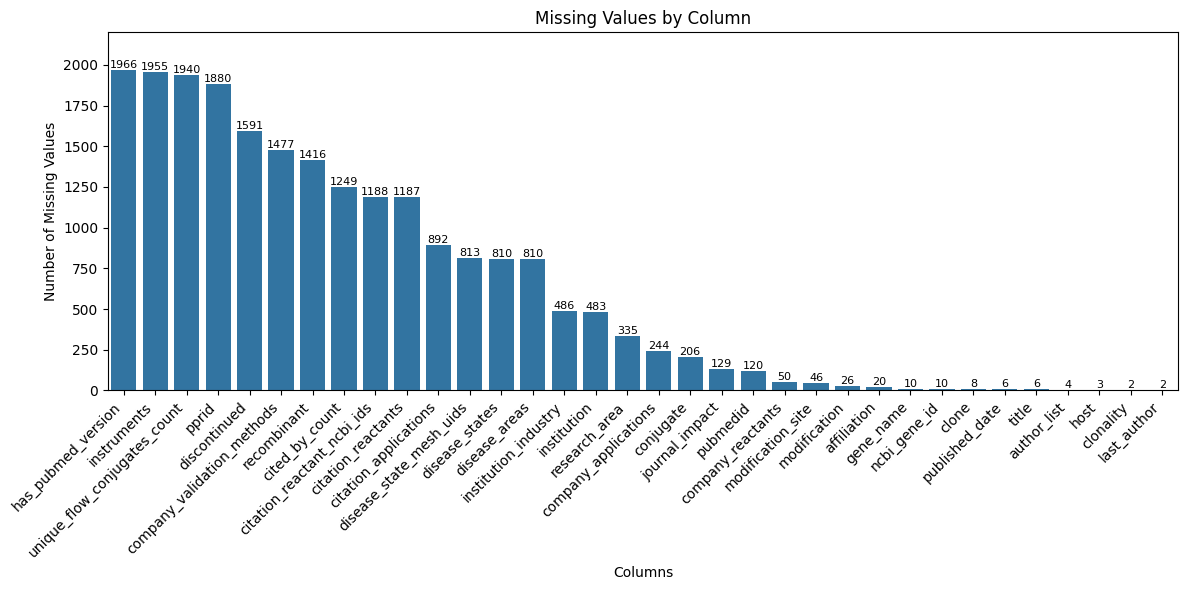

In [7]:
# Visualize missing data
plt.figure(figsize=(12, 6))
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
if not missing_data.empty:
    ax = sns.barplot(x=missing_data.index, y=missing_data.values)
    
    # Add count labels on top of bars
    for i, v in enumerate(missing_data.values):
        ax.text(i, v, str(v), ha='center', va='bottom', fontsize=8)
    
    plt.title('Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.ylim(0, 1.1 * len(df))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in the dataset")

# Create graph from dataframe

In [8]:
# Function create_graph_from_df

from typing import Dict, List, Optional, Union, Tuple
import networkx as nx

def create_graph_from_df(
    df: pd.DataFrame,
    *,
    directed: bool = True,
    source_node_col: Union[str, Dict[str, str]] = 'source',
    target_node_col: Union[str, Dict[str, str]] = 'target',
    attributes_source_node_cols: Union[str, List[str], None] = None,
    attributes_target_node_cols: Union[str, List[str], None] = None,
    optional_nodes_cols: Optional[Dict[str, Dict[str, Union[str, List[str], bool]]]] = None,
    attributes_edges: Union[str, List[str], None] = None,
    edge_type_col: Optional[str] = None,
) -> Union[nx.Graph, nx.DiGraph]:
    """
    Create a NetworkX graph from a pandas DataFrame.
    
    This function converts a DataFrame where each row represents an interaction into a NetworkX graph.
    It handles complex scenarios with multiple node types, attributes, and relationships.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame where each row represents an interaction.
    
    directed : bool, default=True
        Whether to create a directed graph. If True, creates nx.DiGraph, otherwise nx.Graph.
    
    source_node_col : str or Dict[str, str], default='source'
        Column(s) specifying the source node. 
        If str: Name of column containing source node IDs.
        If dict: {
            'id': 'column_name',  # Required: Column containing node IDs
            'displayName': 'column_name',  # Optional: Column containing node labels
            'type': value  # Optional: Can be either:
                           # - A column name containing node types
                           # - A constant string value to use as the type for all nodes
        }
    
    target_node_col : str or Dict[str, str], default='target'
        Column(s) specifying the target node.
        Same format as source_node_col.
    
    attributes_source_node_cols : str, List[str], or None, default=None
        Column(s) containing attributes for source nodes.
    
    attributes_target_node_cols : str, List[str], or None, default=None
        Column(s) containing attributes for target nodes.
    
    optional_nodes_cols : Dict[str, Dict[str, Union[str, List[str], bool]]] or None, default=None
        Specifications for additional node sets in the DataFrame.
        Format: {
            'node_set_name': {
                'id': 'column_name',  # Required: Column containing node IDs
                'displayName': 'column_name',  # Optional: Column containing node labels
                'type': 'column_name',  # Optional: Column containing node types
                'attributes': ['col1', 'col2', ...],  # Optional: Columns for node attributes
                'link_to_source': True,  # Optional: Whether to link to source nodes
                'link_to_target': False,  # Optional: Whether to link to target nodes
                'edge_attributes': ['col1', 'col2', ...]  # Optional: Edge attribute columns
            },
            ...
        }
    
    attributes_edges : str, List[str], or None, default=None
        Column(s) containing edge attributes between source and target nodes.
    
    edge_type_col : str or None, default=None
        Column containing the type/label for edges.
    
    Returns
    -------
    G : nx.DiGraph or nx.Graph
        NetworkX graph with nodes, edges, and attributes as specified.
    
    Notes
    -----
    - Node IDs must be unique and not NaN
    - If label is not specified, node ID is used as label
    - Node attributes are added as node properties in the graph
    - Edge attributes are added as edge properties in the graph
    
    Examples
    --------
    >>> # Simple example with just source and target columns
    >>> G = create_graph_from_df(df, source_node_col='person', target_node_col='movie')
    
    >>> # Complex example with attributes and optional nodes
    >>> G = create_graph_from_df(
    ...     df,
    ...     source_node_col={'id': 'person_id', 'displayName': 'person_name', 'type': 'person_type'},
    ...     target_node_col={'id': 'movie_id', 'displayName': 'movie_title', 'type': 'movie_type'},
    ...     attributes_source_node_cols=['person_age', 'person_gender'],
    ...     attributes_target_node_cols=['movie_year', 'movie_genre'],
    ...     optional_nodes_cols={
    ...         'director': {
    ...             'id': 'director_id',
    ...             'displayName': 'director_name',
    ...             'attributes': ['director_age'],
    ...             'link_to_source': False,
    ...             'link_to_target': True
    ...         }
    ...     },
    ...     attributes_edges=['rating', 'watched_date'],
    ...     edge_type_col='interaction_type'
    ... )
    """
    import pandas as pd
    import numpy as np

    label_str = 'displayName'
    
    # Create a directed or undirected graph
    G = nx.DiGraph() if directed else nx.Graph()
    
    # Helper function to process node columns
    def process_node_info(col_spec):
        if isinstance(col_spec, str):
            return {'id': col_spec, label_str: None, 'type': None, 'is_type_column': False}
        else:
            # Check if 'type' is directly a string (constant type) or a column name
            type_value = col_spec.get('type')
            is_type_column = False
            
            # If type is specified and is a string that exists as a column, it's a column reference
            # Otherwise, it's treated as a constant value
            if (isinstance(type_value, str) and type_value in df.columns):
                is_type_column = True
                
            return {
                'id': col_spec.get('id'),
                label_str: col_spec.get(label_str),
                'type': type_value,
                'is_type_column': is_type_column
            }
    
    # Process node column specifications
    source_info = process_node_info(source_node_col)
    target_info = process_node_info(target_node_col)
    
    # Validate required columns exist in the DataFrame
    required_cols = [source_info['id'], target_info['id']]
    if source_info[label_str]:
        required_cols.append(source_info[label_str])
    if source_info['type'] and source_info['is_type_column']:
        required_cols.append(source_info['type'])
    if target_info[label_str]:
        required_cols.append(target_info[label_str])
    if target_info['type'] and target_info['is_type_column']:
        required_cols.append(target_info['type'])
    
    # Add attribute columns to required columns if specified
    if attributes_source_node_cols:
        if isinstance(attributes_source_node_cols, str):
            required_cols.append(attributes_source_node_cols)
        else:
            required_cols.extend(attributes_source_node_cols)
    
    if attributes_target_node_cols:
        if isinstance(attributes_target_node_cols, str):
            required_cols.append(attributes_target_node_cols)
        else:
            required_cols.extend(attributes_target_node_cols)
    
    if attributes_edges:
        if isinstance(attributes_edges, str):
            required_cols.append(attributes_edges)
        else:
            required_cols.extend(attributes_edges)
    
    if edge_type_col:
        required_cols.append(edge_type_col)
    
    # Check for optional node sets
    if optional_nodes_cols:
        for node_set, config in optional_nodes_cols.items():
            required_cols.append(config['id'])
            if label_str in config and config[label_str]:
                required_cols.append(config[label_str])
            #if 'type' in config and config['type']:
            #    required_cols.append(config['type'])
            if ('type' in config) and config['type'] and (config['type'] in df.columns):
                required_cols.append(config['type'])
            if 'attributes' in config and config['attributes']:
                if isinstance(config['attributes'], str):
                    required_cols.append(config['attributes'])
                else:
                    required_cols.extend(config['attributes'])
            if 'edge_attributes' in config and config['edge_attributes']:
                if isinstance(config['edge_attributes'], str):
                    required_cols.append(config['edge_attributes'])
                else:
                    required_cols.extend(config['edge_attributes'])
    
    # Check if all required columns exist in DataFrame
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns in DataFrame: {missing_cols}")
    
    # Helper function to normalize attributes to a list
    def normalize_attr(attr):
        if attr is None:
            return []
        elif isinstance(attr, str):
            return [attr]
        return list(attr)
    
    # Normalize attribute lists
    source_attrs = normalize_attr(attributes_source_node_cols)
    target_attrs = normalize_attr(attributes_target_node_cols)
    edge_attrs = normalize_attr(attributes_edges)
    
    # Function to add a node to the graph with its attributes
    def add_node_with_attrs(row, node_set, node_id_col, node_label_col, node_type_val, is_type_column, attr_cols, node_prefix=''):
        if pd.isna(row[node_id_col]):
            return None
        
        node_id = row[node_id_col]
        
        # Skip if node_id is NaN
        if pd.isna(node_id):
            return None
            
        # Add node if it doesn't exist yet
        if node_id not in G:
            # Set node attributes
            node_attrs = {}
            
            # Add label if specified
            if node_label_col:
                label = row[node_label_col] if not pd.isna(row[node_label_col]) else node_id
                node_attrs[label_str] = label
            else:
                node_attrs[label_str] = str(node_id)
            
            # Add type if specified
            if node_type_val is not None:
                if is_type_column:
                    # Type from column
                    node_type = row[node_type_val] if not pd.isna(row[node_type_val]) else None
                    if node_type:
                        node_attrs['type'] = node_type
                else:
                    # Type as constant value
                    node_attrs['type'] = node_type_val
            else:
                node_attrs['type'] = node_set
            
            # Add other attributes
            for attr_col in attr_cols:
                if attr_col in row and not pd.isna(row[attr_col]):
                    attr_name = f"{node_prefix}{attr_col}" if node_prefix else attr_col
                    node_attrs[attr_name] = row[attr_col]
            
            G.add_node(node_id, **node_attrs)
        
        return node_id
    
    # Process each row in the DataFrame
    for idx, row in df.iterrows():
        # Add source node
        source_id = add_node_with_attrs(
            row,
            source_info['type'],
            source_info['id'], 
            source_info[label_str], 
            source_info['type'],
            source_info['is_type_column'],
            source_attrs, 
            #node_prefix='source_'
        )
        
        # Add target node
        target_id = add_node_with_attrs(
            row,
            target_info['type'],
            target_info['id'], 
            target_info[label_str], 
            target_info['type'],
            target_info['is_type_column'],
            target_attrs, 
            #node_prefix='target_'
        )
        
        # Skip if either source or target is None
        if source_id is None or target_id is None:
            continue
            
        # Add edge between source and target with attributes
        edge_attributes = {}
        
        # Add edge type if specified
        if edge_type_col and edge_type_col in row and not pd.isna(row[edge_type_col]):
            edge_attributes['type'] = row[edge_type_col]
        
        # Add edge attributes
        for attr_col in edge_attrs:
            if attr_col in row and not pd.isna(row[attr_col]):
                edge_attributes[attr_col] = row[attr_col]
        
        G.add_edge(source_id, target_id, **edge_attributes)
        
        # Process optional node sets
        if optional_nodes_cols:
            for node_set, config in optional_nodes_cols.items():
                # Extract node information
                node_id_col = config['id']
                node_label_col = config.get(label_str)
                
                # Handle node type (column reference or constant value)
                node_type_val = config.get('type')
                is_type_column = False
                if isinstance(node_type_val, str) and node_type_val in df.columns:
                    is_type_column = True
                
                node_attr_cols = normalize_attr(config.get('attributes', []))
                
                # Add optional node
                opt_node_id = add_node_with_attrs(
                    row,
                    node_set,
                    node_id_col, 
                    node_label_col, 
                    node_type_val,
                    is_type_column, 
                    node_attr_cols, 
                    #node_prefix=f"{node_set}_"
                )
                
                if opt_node_id is None:
                    continue
                
                # Connect to source if specified
                if config.get('link_to_source', False) and source_id is not None:
                    edge_attrs_to_source = {}
                    
                    # Add edge attributes if specified
                    if 'edge_attributes' in config:
                        for attr_col in normalize_attr(config['edge_attributes']):
                            if attr_col in row and not pd.isna(row[attr_col]):
                                edge_attrs_to_source[attr_col] = row[attr_col]
                    
                    G.add_edge(source_id, opt_node_id, **edge_attrs_to_source)
                
                # Connect to target if specified
                if config.get('link_to_target', False) and target_id is not None:
                    edge_attrs_to_target = {}
                    
                    # Add edge attributes if specified
                    if 'edge_attributes' in config:
                        for attr_col in normalize_attr(config['edge_attributes']):
                            if attr_col in row and not pd.isna(row[attr_col]):
                                edge_attrs_to_target[attr_col] = row[attr_col]
                    
                    G.add_edge(opt_node_id, target_id, **edge_attrs_to_target)

    def normalize_graph_property_types(G):
        """
        Ensures all values of the same property across graph nodes have a consistent type.
        When mixed types are found, converts all values to the most general type (str).
        
        Args:
            G: A networkx graph
            
        Returns:
            The modified graph (also modifies in-place)
        """
        from collections import defaultdict
        
        # Collect all property names and their types across nodes
        property_types = defaultdict(set)
        
        for node, attrs in G.nodes(data=True):
            for prop, value in attrs.items():
                property_types[prop].add(type(value))
        
        # Identify properties with mixed types
        mixed_properties = {
            prop: types 
            for prop, types in property_types.items() 
            if len(types) > 1
        }
        
        # Convert mixed-type properties to strings
        for node in G.nodes():
            for prop in mixed_properties:
                if prop in G.nodes[node]:
                    G.nodes[node][prop] = str(G.nodes[node][prop])
        
        return G

    G = normalize_graph_property_types(G)
    
    return G

In [9]:
def add_displayName_to_graph(G, from_attr):
    import networkx as nx
    
    # Turing UI needs 'displayName' to be in node attributes to show node label
    displayName = 'displayName'
    
    # Check if displayName already exists in node attributes
    for node, data in G.nodes(data=True):
        if displayName in data:
            print(f"'{displayName}' is already a node attribute")
            return G
            #raise KeyError(f"'{displayName}' is already a node attribute")

    # If from_attr is 'id' or 'label', e.g. attribute names which are used to encode the graph structure
    if from_attr in ['id', 'label']:
        for node in G.nodes:
            G.nodes[node]['displayName'] = node
    else:
        G = nx.relabel_nodes(G, mapping={from_attr: 'displayName'})


def remove_label_attr_from_gml(gml_filename):
    import re

    with open(gml_filename, 'r') as f:
        gml_content = f.read()

    gml_content_replaced = re.sub('\n    label ', '\n    node_id ', gml_content)

    with open(gml_filename, 'w') as f:
        f.write(gml_content_replaced)

In [10]:
label_str = 'displayName'

# Columns not used:
# - discontinued
# - recombinant
# - has_pubmed_version
# - unique_flow_conjugates_count

G = create_graph_from_df(
    df,
    directed=True,
    
    source_node_col={'id': 'citeabid', label_str: 'name', 'type': 'antibody'},
    target_node_col={'id': 'protein_code', label_str: 'protein_code', 'type': 'protein'},

    attributes_source_node_cols=[
        'code', 'company', "clonality", 'clone', 'conjugate', 'primary'
    ],
    attributes_target_node_cols=[
        "recombinant", "primary", "modification", "modification_site",
        "company_applications", "company_reactants", "company_validation_methods",
        "ncbi_gene_id", "gene_name"
    ],
    
    optional_nodes_cols={
        'host': {
            'id': 'host',
            #label_str: '',
            #'attributes': '',
            'link_to_source': True,
            'link_to_target': False,
            #'edge_attributes': ['']
        },
        
        'target': {
            'id': 'target',
            label_str: 'target',
            #'attributes': '',
            'link_to_source': False,
            'link_to_target': True,
            #'edge_attributes': ['']
        },
        'species': {
            'id': 'species',
            #label_str: '',
            #'attributes': ['species'],
            'link_to_source': False,
            'link_to_target': True,
            #'edge_attributes': ['']
        },

        'publication': {
            'id': 'citeab_publication_id',
            label_str: 'citeab_publication_id',
            'attributes': [
                'publication_type', "pubmedid", "pprid",
                #'author_list', "title",
                "cited_by_count",
                'published_year', "published_year",
                'country', 'continent', 'institution', "institution_industry",
                #"research_area", "affiliation",
                #'disease_areas', 'disease_states', "disease_state_mesh_uids",
                #"citation_applications", "citation_reactants", "citation_reactant_ncbi_ids", "instruments"
            ],
            'link_to_source': False,
            'link_to_target': True,
            #'edge_attributes': ['']
        },
        'journal': {
            'id': 'journal',
            #label_str: '',
            'attributes': ['journal_impact'],
            'link_to_source': False,
            'link_to_target': True,
            #'edge_attributes': ['']
        },
    },
    #attributes_edges=['rating', 'watched_date'],
    #edge_type_col='interaction_type'
)
print(f"Resulting graph : {G}")

#add_displayName_to_graph(G, label_str)
nx.write_gml(G, f"{path_data}/{example_name}.gml")
remove_label_attr_from_gml(f"{path_data}/{example_name}.gml")

Resulting graph : DiGraph with 2714 nodes and 3134 edges


In [11]:
n_first = 10

print("NODES :")
for node in list(G.nodes(data=True))[:n_first]:
    print(node[0])
    for key, val in node[1].items():
        print(f"   {key} : {val} (type: {type(val)})")

    print()
print()

print("EDGES :")
for edge in list(G.edges(data=True))[:n_first]:
    print(edge)

NODES :
2390688
   displayName : c-erbB-2 Oncoprotein (type: <class 'str'>)
   type : antibody (type: <class 'str'>)
   code : A0485 (type: <class 'str'>)
   company : Dako (type: <class 'str'>)
   clonality : Polyclonal (type: <class 'str'>)
   clone : not_applicable (type: <class 'str'>)
   conjugate : Unconjugated (type: <class 'str'>)
   primary : Primary (type: <class 'str'>)

P04626
   displayName : P04626 (type: <class 'str'>)
   type : protein (type: <class 'str'>)
   primary : Primary (type: <class 'str'>)
   modification : Unmodified (type: <class 'str'>)
   modification_site : not_applicable (type: <class 'str'>)
   company_applications : IHC (type: <class 'str'>)
   company_reactants : Homo sapiens (Human) (type: <class 'str'>)
   ncbi_gene_id : 2064 (type: <class 'str'>)
   gene_name : ERBB2 (type: <class 'str'>)

Rabbit
   displayName : Rabbit (type: <class 'str'>)
   type : host (type: <class 'str'>)

Receptor tyrosine-protein kinase erbB-2
   displayName : Receptor tyro

# Create Cypher CREATE command

## Build CREATE command

In [12]:
%%time

# Build CREATE command from networkx object
graph_CREATE_command = build_create_command_from_networkx(G)
print(f"""
Cypher CREATE command :
* size: {len(graph_CREATE_command.encode('utf-8'))/1024/1000:.4f} MB\n
{100 * '*'}
{graph_CREATE_command if len(graph_CREATE_command.split("\n")) < 1000 else "\n".join(graph_CREATE_command.split('\n')[:10]) + "\n...\n" + "\n".join(graph_CREATE_command.split('\n')[-10:])}
{100 * '*'}
""")

Cypher query will create graph with 2,714 nodes and 3,134 edges

Cypher CREATE command :
* size: 0.8973 MB

****************************************************************************************************
CREATE (:Antibody {id: "2390688", displayName: "c-erbB-2 Oncoprotein", type: "antibody", code: "A0485", company: "Dako", clonality: "Polyclonal", clone: "not_applicable", conjugate: "Unconjugated", primary: "Primary"}),
(:Protein {id: "P04626", displayName: "P04626", type: "protein", primary: "Primary", modification: "Unmodified", modification_site: "not_applicable", company_applications: "IHC", company_reactants: "Homo sapiens (Human)", ncbi_gene_id: "2064", gene_name: "ERBB2"}),
(:Host {id: "Rabbit", displayName: "Rabbit", type: "host"}),
(:Target {id: "Receptor tyrosine-protein kinase erbB-2", displayName: "Receptor tyrosine-protein kinase erbB-2", type: "target"}),
(:Species {id: "Homo sapiens", displayName: "Homo sapiens", type: "species"}),
(:Publication {id: "3933770", disp

## Split command into chunks

In [13]:
%%time

chunks = split_cypher_commands(graph_CREATE_command, max_size_mb=1)

print(f"✓ Split into {len(chunks['node_chunks'])} node chunk(s) and {len(chunks['edge_chunks'])} edge chunk(s)")

print("\nNode chunks:")
for i, chunk in enumerate(chunks['node_chunks']):
    print(f"  Node chunk {i+1}: {len(chunk.encode('utf-8'))/1024:.1f} KB")
    if i == 10:
        print("  ...")
        break
        
print("\nEdge chunks:")
for i, chunk in enumerate(chunks['edge_chunks']):
    print(f"  Edge chunk {i+1}: {len(chunk.encode('utf-8'))/1024:.1f} KB")
    if i == 10:
        print("  ...")
        break

✓ Split into 1 node chunk(s) and 3134 edge chunk(s)

Node chunks:
  Node chunk 1: 601.6 KB

Edge chunks:
  Edge chunk 1: 0.1 KB
  Edge chunk 2: 0.1 KB
  Edge chunk 3: 0.1 KB
  Edge chunk 4: 0.1 KB
  Edge chunk 5: 0.1 KB
  Edge chunk 6: 0.1 KB
  Edge chunk 7: 0.1 KB
  Edge chunk 8: 0.1 KB
  Edge chunk 9: 0.1 KB
  Edge chunk 10: 0.1 KB
  Edge chunk 11: 0.1 KB
  ...
CPU times: user 37.7 ms, sys: 976 μs, total: 38.6 ms
Wall time: 37.8 ms


# Create graph using `turingdb` python package

<div class="alert alert-block alert-info">
    <h2>
        See <a href="https://docs.turingdb.ai/quickstart">TuringDB Get started documentation</a> for the important steps to follow :
    </h2>
    <h4>
        <ul>
            <li>Create your TuringDB account</li>
            <li>Create your instance in the <a href="https://console.turingdb.ai/auth">TuringDB Cloud UI</a></li>
            <li>Copy your Instance ID from the Database Instances management page</li>
            <li>Get API Key from the Settings in UI</li>
        </ul>
        Remember to have your instance active while working in this notebook !
    </h4>
</div>

In [14]:
from turingdb import TuringDB

# Create TuringDB client
# set host parameter to the URL (as string) on which TuringDB is running,
# default "http://localhost:6666"
client = TuringDB(host="http://localhost:6666")
try:
    client.warmup()
except Exception as e:
    print(f"TuringDB not started, please run `uv run turingdb` in your terminal")

In [15]:
# Get list of available graphs
list_graphs = client.list_available_graphs()

In [16]:
client.list_loaded_graphs()

['default']

In [17]:
# Set graph name
graph_name_prefix = example_name
graph_name_nb_suffix = str(
    max(
        [
            int(re.sub(graph_name_prefix, "", g))
            for g in list_graphs
            if g.startswith(graph_name_prefix)
            and re.sub(graph_name_prefix, "", g).isdigit()
        ]
        + [0]
    )
    + 1
)
graph_name = graph_name_prefix + graph_name_nb_suffix
graph_name = re.sub("-", "_", graph_name)
graph_name

'citeab_antibody1'

In [18]:
from turingdb.exceptions import TuringDBException

In [19]:
%%time

# Create graph
try:
    client.create_graph(graph_name)
except TuringDBException as e:
    print(e)

# Set working graph
client.set_graph(graph_name)

CPU times: user 1.75 ms, sys: 0 ns, total: 1.75 ms
Wall time: 19.2 ms


In [20]:
%%time

# Create a new change on the graph
change = client.new_change()
print(f"Current change {change}")

# Checkout into the change
client.checkout(change=change)

Current change 0
CPU times: user 2.18 ms, sys: 13 μs, total: 2.2 ms
Wall time: 1.53 ms


In [21]:
%%time

# Run CREATE command
print("\nExecuting query on TuringDB...")
start_time = time.time()

print(f"✓ Split into {len(chunks['node_chunks'])} node chunk(s) and {len(chunks['edge_chunks'])} edge chunk(s)")

# CREATE nodes
print("\nNode chunks:")
for i, chunk in enumerate(tqdm(chunks['node_chunks'])):
    result = client.query(chunk)
# Commit the change
client.query("COMMIT")
print(f"✓ {len(chunks['node_chunks'])} node chunks done")

# CREATE edges
print("\nEdge chunks:")
for i, chunk in enumerate(tqdm(chunks['edge_chunks'])):
    result = client.query(chunk)
# Commit the change
client.query("COMMIT")
print(f"✓ {len(chunks['edge_chunks'])} edge chunks done")

execution_time = time.time() - start_time
print(f"\n✓ Graph created successfully in {execution_time:.2f} seconds")

# Submit changes
start_time = time.time()
client.query("CHANGE SUBMIT")
execution_time = time.time() - start_time
print(f"\n✓ Changes successfully submitted in {execution_time:.2f} seconds")

# Checkout into main
client.checkout()


Executing query on TuringDB...
✓ Split into 1 node chunk(s) and 3134 edge chunk(s)

Node chunks:


  0%|          | 0/1 [00:00<?, ?it/s]

✓ 1 node chunks done

Edge chunks:


  0%|          | 0/3134 [00:00<?, ?it/s]

✓ 3134 edge chunks done

✓ Graph created successfully in 3.45 seconds

✓ Changes successfully submitted in 0.10 seconds
CPU times: user 2.27 s, sys: 129 ms, total: 2.4 s
Wall time: 3.55 s


In [22]:
# Returns the commit history
client.query("CALL db.history()")

,commit,nodeCount,edgeCount,partCount
0,ca62ca2473632dbf,0,0,0
1,54dd1d40b6ee3aa9,2714,0,1
2,8f85120bf52013be,0,3134,1
3,3e11773e529e8446,0,0,0


<div class="alert alert-block alert-info">
    <h2>
        Visualize your graph in TuringDB Graph Visualizer ! Now that your instance is running:
    </h2>
    <h3>
        <ul>
            <li>Go to <a href="https://console.turingdb.ai/databases">TuringDB Console - Database Instances</a></li>
            <li>In your current instance panel, click on "Open Visualizer" button</li>
            <li>Visualizer opens, now you can choose your graph in the dropdown menu at the top-right corner</li>
        </ul>
        You can then play with your graph and visualize the nodes you want !
    </h3>
</div>

# Query TuringDB

## Use metaqueries to have insight on graph overall structure

<h3>
    To learn more about 📮 Metaqueries, please check TuringDB documentation on this <a href="https://turingdb.mintlify.app/query/cypher_subset#%F0%9F%93%AE-metaqueries">link</a>
</h3>

In [23]:
%%time

# CALL propertyTypes() - returns a column of all the different node and edge properties and their types in the database
command = """
CALL db.propertyTypes()
"""
df_propertyTypes = client.query(command)
if df_propertyTypes.empty:
    print("No result found")
else:
    display(df_propertyTypes)

,id,propertyType,valueType
0,0,conjugate,String
1,1,primary,String
2,2,clonality,String
3,3,code,String
4,4,clone,String
5,5,type,String
6,6,company,String
7,7,displayName,String
8,8,id,String
9,9,company_reactants,String


CPU times: user 4.31 ms, sys: 948 μs, total: 5.25 ms
Wall time: 4.71 ms


In [24]:
# Get node properties
nodes_properties = df_propertyTypes["propertyType"].values.tolist()
print(f"Node properties: {nodes_properties}")

Node properties: ['conjugate', 'primary', 'clonality', 'code', 'clone', 'type', 'company', 'displayName', 'id', 'company_reactants', 'company_applications', 'modification_site', 'modification', 'ncbi_gene_id', 'gene_name', 'country', 'published_year', 'pubmedid', 'publication_type', 'continent', 'journal_impact', 'institution_industry', 'institution', 'cited_by_count', 'pprid', 'recombinant', 'company_validation_methods']


In [25]:
%%time

# CALL labels () - returns a column of all the different node labels
command = """
CALL db.labels()
"""
df_labels = client.query(command)
if df_labels.empty:
    print("No result found")
else:
    display(df_labels)

,id,label
0,0,Antibody
1,1,Protein
2,2,Host
3,3,Target
4,4,Species
5,5,Publication
6,6,Journal


CPU times: user 3.99 ms, sys: 74 μs, total: 4.07 ms
Wall time: 3.67 ms


In [26]:
%%time

# CALL edgeTypes() - returns a column of all the different edge types (edge equivalent of node labels)
command = """
CALL db.edgeTypes()
"""
df_edgeTypes = client.query(command)
if df_edgeTypes.empty:
    print("No result found")
else:
    display(df_edgeTypes)

,id,edgeType
0,0,CONNECTED


CPU times: user 3.98 ms, sys: 0 ns, total: 3.98 ms
Wall time: 3.6 ms


## Counts

In [27]:
%%time

# Find number of nodes and number of edges in the graph
n_nodes = len(client.query("MATCH (n) RETURN n"))
n_edges = len(client.query("MATCH (n)-->(m) RETURN n, m"))
print(f"Graph: {n_nodes:,} nodes and {n_edges:,} edges")

Graph: 2,714 nodes and 3,134 edges
CPU times: user 2.58 ms, sys: 977 μs, total: 3.56 ms
Wall time: 3.3 ms


In [28]:
%%time

# Count all nodes
command = """
MATCH (n)
RETURN COUNT(n)
"""
df_count_nodes = client.query(command)
display(df_count_nodes)
#print(df_count_nodes.loc[0, "COUNT(n)"])
# isinstance(client.query(command).loc[0, "COUNT(n)"], int)

# Count all edges
command = """
MATCH (n)-->()
RETURN COUNT(n)
"""
df_count_edges = client.query(command)
display(df_count_edges)

# Find number of nodes and number of edges in the graph
n_nodes = int(df_count_nodes.loc[0, "COUNT(n)"])
n_edges = int(df_count_edges.loc[0, "COUNT(n)"])
print(f"Graph: {n_nodes:,} nodes and {n_edges:,} edges")

,COUNT(n)
0,2714


,COUNT(n)
0,3134


Graph: 2,714 nodes and 3,134 edges
CPU times: user 6.11 ms, sys: 931 μs, total: 7.04 ms
Wall time: 6.43 ms


In [29]:
# Count number of nodes for each label
for label in df_labels["label"]:
    print(100 * '-')
    print(f"label: {label}")
    df_curr_label = client.query(f"""
    MATCH (n:{label})
    RETURN n.displayName
    """)
    df_curr_label_count = client.query(f"""
    MATCH (n:{label})
    RETURN count(n)
    """)
    display(df_curr_label)
    display(df_curr_label_count)
    
    print()
print(100 * '-')

----------------------------------------------------------------------------------------------------
label: Antibody


,n.displayName
0,Anti-p53 antibody [EPR17343]
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],..."
2,Anti-p53 antibody [DO-1] - ChIP Grade
3,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody
4,Anti-p53 (acetyl K381) antibody
...,...
254,Anti-p53 (acetyl K370) antibody [EPR17496]
255,Anti-p53 (phospho S6) antibody [Y179]
256,P53 Polyclonal antibody
257,p53 (1C12) Mouse mAb


,count(n)
0,259



----------------------------------------------------------------------------------------------------
label: Protein


,n.displayName
0,F5H1T4
1,P56423
2,P10361
3,P70424
4,P04637
5,P79734
6,P04626


,count(n)
0,7



----------------------------------------------------------------------------------------------------
label: Host


,n.displayName
0,Mouse
1,Human
2,Rat
3,Rabbit
4,Goat
5,Sheep
6,Chicken
7,Recombinant


,count(n)
0,8



----------------------------------------------------------------------------------------------------
label: Target


,n.displayName
0,Receptor tyrosine-protein kinase erbB-2
1,receptor protein-tyrosine kinase
2,Cellular tumor antigen p53


,count(n)
0,3



----------------------------------------------------------------------------------------------------
label: Species


,n.displayName
0,Rattus norvegicus
1,Danio rerio
2,Mus musculus
3,Homo sapiens
4,Macaca fascicularis


,count(n)
0,5



----------------------------------------------------------------------------------------------------
label: Publication


,n.displayName
0,34881518
1,154755
2,85315
3,38496011
4,3355788
...,...
1910,30976853
1911,34424252
1912,159370
1913,2713013


,count(n)
0,1915



----------------------------------------------------------------------------------------------------
label: Journal


,n.displayName
0,Int J Biol Sci
1,Mol Cancer Res
2,Cell Rep Med
3,Acta Neuropathol Commun
4,Hepatology
...,...
512,Anticancer Drugs
513,Chonnam Med J
514,medRxiv
515,Exp Biol Med (Maywood)


,count(n)
0,517



----------------------------------------------------------------------------------------------------


## Queries

In [30]:
%%time

# Match all nodes and return them
command = """
MATCH (n)
RETURN n.displayName, n.type
"""
df_all_nodes = client.query(command)
if df_all_nodes.empty:
    print("No result found")
else:
    display(df_all_nodes)

,n.displayName,n.type
0,Anti-p53 antibody [EPR17343],antibody
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",antibody
2,Anti-p53 antibody [DO-1] - ChIP Grade,antibody
3,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody,antibody
4,Anti-p53 (acetyl K381) antibody,antibody
...,...,...
2709,Anticancer Drugs,journal
2710,Chonnam Med J,journal
2711,medRxiv,journal
2712,Exp Biol Med (Maywood),journal


CPU times: user 4.24 ms, sys: 1.02 ms, total: 5.26 ms
Wall time: 5.13 ms


In [31]:
%%time

# Match all edges and return them
command = """
MATCH (n)-[e]->(m)
RETURN n.displayName, n.type, e, m.displayName, m.type
"""
df_all_edges = client.query(command)
if df_all_edges.empty:
    print("No result found")
else:
    display(df_all_edges)

,n.displayName,n.type,e,m.displayName,m.type
0,Anti-p53 antibody [EPR17343],antibody,0,P04637,protein
1,Anti-p53 antibody [EPR17343],antibody,1,Rabbit,host
2,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",antibody,2,P04626,protein
3,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",antibody,3,Human,host
4,Anti-p53 antibody [DO-1] - ChIP Grade,antibody,4,P04637,protein
...,...,...,...,...,...
3129,Anticancer Drugs,journal,3129,P04626,protein
3130,Chonnam Med J,journal,3130,P04637,protein
3131,medRxiv,journal,3131,P04626,protein
3132,Exp Biol Med (Maywood),journal,3132,P04637,protein


CPU times: user 7.27 ms, sys: 940 μs, total: 8.21 ms
Wall time: 8.4 ms


In [32]:
%%time

# Get all antibodies
command = """
MATCH (ab)
WHERE ab.type = 'antibody'
RETURN ab.displayName, ab.company, ab.clonality, ab.code
"""
df_antibodies = client.query(command)
if df_antibodies.empty:
    print("No result found")
else:
    display(df_antibodies)

,ab.displayName,ab.company,ab.clonality,ab.code
0,Anti-p53 antibody [EPR17343],Abcam,Monoclonal,ab179477
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",Absolute Antibody,Monoclonal,Ab00103-10.0
2,Anti-p53 antibody [DO-1] - ChIP Grade,Abcam,Monoclonal,ab1101
3,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody,Bioworld,Polyclonal,BS4091
4,Anti-p53 (acetyl K381) antibody,Abcam,Polyclonal,ab61241
...,...,...,...,...
254,Anti-p53 (acetyl K370) antibody [EPR17496],Abcam,Monoclonal,ab183544
255,Anti-p53 (phospho S6) antibody [Y179],Abcam,Monoclonal,ab32132
256,P53 Polyclonal antibody,Proteintech,Polyclonal,21891-1-AP
257,p53 (1C12) Mouse mAb,Cell Signaling Technology,Monoclonal,2524


CPU times: user 5.96 ms, sys: 2 μs, total: 5.97 ms
Wall time: 5.61 ms


In [33]:
%%time

# Count antibodies
command = """
MATCH (ab)
WHERE ab.type = 'antibody'
RETURN COUNT(ab)
"""
df_count = client.query(command)
if df_count.empty:
    print("No result found")
else:
    display(df_count)

,COUNT(ab)
0,259


CPU times: user 3.63 ms, sys: 53 μs, total: 3.68 ms
Wall time: 3.28 ms


In [34]:
%%time

# Count antibodies
command = """
MATCH (ab)
WHERE ab:Antibody
RETURN COUNT(ab)
"""
df_count = client.query(command)
if df_count.empty:
    print("No result found")
else:
    display(df_count)

,COUNT(ab)
0,259


CPU times: user 4.17 ms, sys: 100 μs, total: 4.27 ms
Wall time: 3.78 ms


In [35]:
%%time

# Find antibodies with most publications
command = """
MATCH (ab)-->(prot)<--(pub)
WHERE ab.type = 'antibody'
AND prot.type = 'protein'
AND pub.type = 'publication'
RETURN ab.displayName, ab.company,
    prot.displayName, prot.gene_name, prot.ncbi_gene_id,
    pub.displayName, pub.pubmedid, pub.published_year
"""
df_top_antibodies = client.query(command)
if df_top_antibodies.empty:
    print("No result found")
else:
    display(df_top_antibodies)
    display(pd.DataFrame(df_top_antibodies["pub.displayName"].value_counts()))

,ab.displayName,ab.company,prot.displayName,prot.gene_name,prot.ncbi_gene_id,pub.displayName,pub.pubmedid,pub.published_year
0,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,34870420,35757005.0,2022
1,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,2545662,28848389.0,2017
2,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,30657245,33101585.0,2020
3,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,4134791,30542737.0,2018
4,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,37911186,38709242.0,2024
...,...,...,...,...,...,...,...,...
239333,ErbB2/HER2 Antibody (F-11),Santa Cruz Biotechnology,P04626,ERBB2,2064,8567,18076984.0,2008
239334,ErbB2/HER2 Antibody (F-11),Santa Cruz Biotechnology,P04626,ERBB2,2064,35544609,36395883.0,2022
239335,ErbB2/HER2 Antibody (F-11),Santa Cruz Biotechnology,P04626,ERBB2,2064,4015047,16965995.0,2006
239336,ErbB2/HER2 Antibody (F-11),Santa Cruz Biotechnology,P04626,ERBB2,2064,30367664,32064314.0,2019


,count
pub.displayName,
37341459,251
36134886,251
123523,251
36091546,251
3346931,251
...,...
2565882,1
34128236,1
32872623,1


CPU times: user 266 ms, sys: 207 ms, total: 472 ms
Wall time: 629 ms


In [36]:
%%time

# Find antibodies targeting proteins
command = """
MATCH (ab)-->(prot)
WHERE ab.type = 'antibody'
AND prot.type = 'protein'
RETURN ab.displayName, ab.company, prot.displayName, prot.gene_name, prot.ncbi_gene_id
"""
df_antibody_proteins = client.query(command)
if df_antibody_proteins.empty:
    print("No result found")
else:
    print(f"Total antibody-protein connections: {len(df_antibody_proteins)}")
    # Find most targeted proteins
    print("\nMost targeted proteins:")
    print(df_antibody_proteins.groupby('prot.gene_name').size().sort_values(ascending=False))
    display(df_antibody_proteins)

Total antibody-protein connections: 259

Most targeted proteins:
prot.gene_name
ERBB2    127
TP53     126
Erbb2      3
Tp53       2
tp53       1
dtype: int64


,ab.displayName,ab.company,prot.displayName,prot.gene_name,prot.ncbi_gene_id
0,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",Absolute Antibody,P04626,ERBB2,2064
2,Anti-p53 antibody [DO-1] - ChIP Grade,Abcam,P04637,TP53,7157
3,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody,Bioworld,P04626,ERBB2,2064
4,Anti-p53 (acetyl K381) antibody,Abcam,P04637,TP53,7157
...,...,...,...,...,...
254,Anti-p53 (acetyl K370) antibody [EPR17496],Abcam,P04637,TP53,7157
255,Anti-p53 (phospho S6) antibody [Y179],Abcam,P04637,TP53,7157
256,P53 Polyclonal antibody,Proteintech,P04637,TP53,7157
257,p53 (1C12) Mouse mAb,Cell Signaling Technology,P04637,TP53,7157


CPU times: user 8.06 ms, sys: 117 μs, total: 8.18 ms
Wall time: 7.38 ms


In [37]:
%%time

# Get all publications
command = """
MATCH (pub)
WHERE pub.type = 'publication'
AND pub.pubmedid > 0
RETURN pub.displayName, pub.pubmedid, pub.published_year, pub.country, pub.cited_by_count
"""
df_publications = client.query(command)
if df_publications.empty:
    print("No result found")
else:
    display(df_publications)

,pub.displayName,pub.pubmedid,pub.published_year,pub.country,pub.cited_by_count
0,34881518,35765591.0,2022,China,1.0
1,154755,24555657.0,2014,Brazil,NaN
2,85315,21099353.0,2010,United States,NaN
3,38496011,39063073.0,2024,Canada,NaN
4,3355788,11706075.0,2001,United States,NaN
...,...,...,...,...,...
1794,30976853,32929011.0,2020,United States,NaN
1795,34424252,35344993.0,2022,United States,1.0
1796,159370,20371474.0,2010,United States,NaN
1797,2713013,28775303.0,2017,United States,154.0


CPU times: user 7.11 ms, sys: 901 μs, total: 8.01 ms
Wall time: 8.69 ms


In [38]:
%%time

# Antibodies used in publications
command = """
MATCH (ab)-->(prot)<--(pub)
WHERE ab.type = 'antibody'
AND prot.type = 'protein'
AND pub.type = 'publication'
RETURN ab.displayName, ab.company,
    prot.displayName, prot.gene_name, prot.ncbi_gene_id,
    pub.displayName, pub.pubmedid, pub.published_year
"""
df_ab_pubs = client.query(command)
if df_ab_pubs.empty:
    print("No result found")
else:
    display(df_ab_pubs)

,ab.displayName,ab.company,prot.displayName,prot.gene_name,prot.ncbi_gene_id,pub.displayName,pub.pubmedid,pub.published_year
0,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,34870420,35757005.0,2022
1,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,2545662,28848389.0,2017
2,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,30657245,33101585.0,2020
3,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,4134791,30542737.0,2018
4,Anti-p53 antibody [EPR17343],Abcam,P04637,TP53,7157,37911186,38709242.0,2024
...,...,...,...,...,...,...,...,...
239333,ErbB2/HER2 Antibody (F-11),Santa Cruz Biotechnology,P04626,ERBB2,2064,8567,18076984.0,2008
239334,ErbB2/HER2 Antibody (F-11),Santa Cruz Biotechnology,P04626,ERBB2,2064,35544609,36395883.0,2022
239335,ErbB2/HER2 Antibody (F-11),Santa Cruz Biotechnology,P04626,ERBB2,2064,4015047,16965995.0,2006
239336,ErbB2/HER2 Antibody (F-11),Santa Cruz Biotechnology,P04626,ERBB2,2064,30367664,32064314.0,2019


CPU times: user 241 ms, sys: 186 ms, total: 427 ms
Wall time: 607 ms


In [39]:
%%time

# Get publications with journal info
command = """
MATCH (pub)-->(prot)<--(j)
WHERE pub.type = 'publication'
AND prot.type = 'protein'
AND j.type = 'journal'
AND j.journal_impact > 10
RETURN pub.displayName, prot.displayName, j.displayName, j.journal_impact, pub.published_year
"""
df_high_journals = client.query(command)
if df_high_journals.empty:
    print("No result found")
else:
    display(df_high_journals)

,pub.displayName,prot.displayName,j.displayName,j.journal_impact,pub.published_year
0,34881518,P04637,J Hematol Oncol,18.092,2022
1,34881518,P04637,Cell Death Differ,10.827,2022
2,34881518,P04637,Nat Cancer,13.051,2022
3,34881518,P04637,Nat Genet,26.796,2022
4,34881518,P04637,Nat Protoc,12.824,2022
...,...,...,...,...,...
44837,34846086,P04626,J Extracell Vesicles,12.487,2022
44838,34846086,P04626,Cell Metab,17.869,2022
44839,34846086,P04626,Nat Mater,21.145,2022
44840,34846086,P04626,Cancer Discov,17.105,2022


CPU times: user 92 ms, sys: 13 ms, total: 105 ms
Wall time: 283 ms


In [40]:
%%time

# Antibodies from a specific company
command = """
MATCH (ab)
WHERE ab.type = 'antibody'
AND ab.company = 'Cell Signaling Technology'
RETURN ab.displayName, ab.code, ab.clonality
"""
df_cst = client.query(command)
if df_cst.empty:
    print("No result found")
else:
    display(df_cst)

,ab.displayName,ab.code,ab.clonality
0,Phospho-p53 (Ser20) Antibody,9287,Polyclonal
1,Phospho-p53 (Ser15) (16G8) Mouse mAb,9286,Monoclonal
2,Phospho-p53 (Ser46) Antibody,2521,Polyclonal
3,HER2/ErbB2 (29D8) Rabbit mAb (PE Conjugate),98710,Monoclonal
4,HER2/ErbB2 (29D8) Rabbit mAb (HRP Conjugate),60388,Monoclonal
5,Phospho-p53 (Ser392) Antibody,9281,Polyclonal
6,p53 (7F5) Rabbit mAb,2527,Monoclonal
7,p53 (E9B5W) Rabbit mAb,30313,Monoclonal
8,Phospho-p53 (Thr81) Antibody,2676,Polyclonal
9,Phospho-p53 (Ser15) Antibody,9284,Polyclonal


CPU times: user 5.71 ms, sys: 0 ns, total: 5.71 ms
Wall time: 5.32 ms


In [41]:
%%time

# Get all monoclonal antibodies
command = """
MATCH (ab)
WHERE ab.type = 'antibody'
AND ab.clonality = 'Monoclonal'
AND ab.company IS NOT NULL
RETURN ab.displayName, ab.company, ab.clone
"""
df_monoclonal = client.query(command)
if df_monoclonal.empty:
    print("No result found")
else:
    display(df_monoclonal)

,ab.displayName,ab.company,ab.clone
0,Anti-p53 antibody [EPR17343],Abcam,EPR17343
1,"Anti-erbB-2 (Her-2/neu) [4D5-8 (trastuzumab)],...",Absolute Antibody,4D5-8 (trastuzumab)
2,Anti-p53 antibody [DO-1] - ChIP Grade,Abcam,DO-1
3,"ErbB-2 (CD340) Antibody, anti-human, APC, REAf...",Miltenyi Biotec,REA1232
4,Phospho-p53 (Ser15) (16G8) Mouse mAb,Cell Signaling Technology,16G8A1A3A1A1
...,...,...,...
156,p53 Monoclonal Antibody (SP5),Invitrogen Antibodies,SP5
157,Anti-p53 (acetyl K370) antibody [EPR17496],Abcam,EPR17496
158,Anti-p53 (phospho S6) antibody [Y179],Abcam,Y179
159,p53 (1C12) Mouse mAb,Cell Signaling Technology,1C12G11A1E8B1


CPU times: user 4.49 ms, sys: 1.06 ms, total: 5.55 ms
Wall time: 5.41 ms


In [42]:
%%time

# Find antibodies used together in same publication (2-hop)
command = """
MATCH (ab1)-->(prot), (ab2)-->(prot)
WHERE ab1.type = 'antibody'
AND ab2.type = 'antibody'
AND prot.type = 'protein'
AND ab1.displayName <> ab2.displayName
RETURN ab1.displayName, ab2.displayName, prot.displayName, prot.gene_name
"""
df_co_cited = client.query(command)
if df_co_cited.empty:
    print("No result found")
else:
    display(df_co_cited)

,ab1.displayName,ab2.displayName,prot.displayName,prot.gene_name
0,Anti-p53 antibody [EPR17343],Anti-p53 antibody [DO-1] - ChIP Grade,P04637,TP53
1,Anti-p53 antibody [EPR17343],Anti-p53 (acetyl K381) antibody,P04637,TP53
2,Anti-p53 antibody [EPR17343],Phospho-p53 (Ser20) Antibody,P04637,TP53
3,Anti-p53 antibody [EPR17343],p53 Antibody,P04637,TP53
4,Anti-p53 antibody [EPR17343],Phospho-p53 (Ser15) (16G8) Mouse mAb,P04637,TP53
...,...,...,...,...
31191,ErbB2/HER2 Antibody (F-11),BD Horizon BV421 Mouse Anti-Human CD340 (HER-2),P04626,ERBB2
31192,ErbB2/HER2 Antibody (F-11),Anti-phospho-erbB-2/HER-2 (Tyr1248) Antibody,P04626,ERBB2
31193,ErbB2/HER2 Antibody (F-11),Anti-phospho-ERBB2 (pTyr877) antibody produced...,P04626,ERBB2
31194,ErbB2/HER2 Antibody (F-11),PE anti-human CD340 (erbB2/HER-2) Antibody,P04626,ERBB2


CPU times: user 19.6 ms, sys: 8.94 ms, total: 28.5 ms
Wall time: 54.6 ms


In [43]:
%%time

# Publications published on 2020 or after
command = """
MATCH (pub)
WHERE pub.published_year >= 2020
AND pub.type = 'publication'
RETURN pub.displayName, pub.pubmedid, pub.published_year, pub.country
"""
df_recent = client.query(command)
if df_recent.empty:
    print("No result found")
else:
    display(df_recent)

,pub.displayName,pub.pubmedid,pub.published_year,pub.country
0,34881518,35765591.0,2022,China
1,38496011,39063073.0,2024,Canada
2,36481166,37324464.0,2023,China
3,35832724,36674872.0,2023,Germany
4,35293354,36150611.0,2023,Unknown
...,...,...,...,...
792,30873349,33061459.0,2020,China
793,36798084,37608616.0,2023,Germany
794,30976853,32929011.0,2020,United States
795,34424252,35344993.0,2022,United States


CPU times: user 6.68 ms, sys: 0 ns, total: 6.68 ms
Wall time: 7.31 ms


In [44]:
%%time

# Publications from United States
command = """
MATCH (pub)
WHERE pub.type = 'publication'
AND pub.country = 'United States'
AND pub.institution IS NOT NULL
RETURN pub.displayName, pub.institution, pub.published_year, pub.cited_by_count
"""
df_us_pubs = client.query(command)
if df_us_pubs.empty:
    print("No result found")
else:
    display(df_us_pubs)

,pub.displayName,pub.institution,pub.published_year,pub.cited_by_count
0,85315,Roswell Park Cancer Institute,2010,NaN
1,3355788,University of Texas,2001,NaN
2,928355,"University of California, Los Angeles",2013,NaN
3,36124048,Memorial Sloan Kettering Cancer Center,2023,NaN
4,31940663,University of Wisconsin,2021,8.0
...,...,...,...,...
450,4339449,"University of California, Davis",2019,117.0
451,116419,Emory University,2013,NaN
452,30976853,Dana-Farber Cancer Institute,2020,NaN
453,34424252,"University of California, San Francisco",2022,1.0


CPU times: user 4.57 ms, sys: 1.81 ms, total: 6.38 ms
Wall time: 7.23 ms


In [45]:
%%time

# Antibodies derived from rabbit
command = """
MATCH (ab)-->(spec)
WHERE ab.type = 'antibody'
AND spec.displayName = 'Rabbit'
RETURN ab.displayName, ab.company, ab.clonality
"""
df_rabbit = client.query(command)
if df_rabbit.empty:
    print("No result found")
else:
    display(df_rabbit)

,ab.displayName,ab.company,ab.clonality
0,Anti-p53 antibody [EPR17343],Abcam,Monoclonal
1,ErbB2/HER2 (phospho-Y877) Polyclonal Antibody,Bioworld,Polyclonal
2,Anti-p53 (acetyl K381) antibody,Abcam,Polyclonal
3,Anti-ErbB2 / HER2 antibody,Abcam,Polyclonal
4,Phospho-p53 (Ser20) Antibody,Cell Signaling Technology,Polyclonal
...,...,...,...
117,p53 Monoclonal Antibody (SP5),Invitrogen Antibodies,Monoclonal
118,p53 Rabbit pAb,ABclonal,Polyclonal
119,Anti-p53 (acetyl K370) antibody [EPR17496],Abcam,Monoclonal
120,Anti-p53 (phospho S6) antibody [Y179],Abcam,Monoclonal


CPU times: user 5.13 ms, sys: 154 μs, total: 5.28 ms
Wall time: 5.18 ms


In [46]:
%%time

# Count Harvard publications
command = """
MATCH (pub)
WHERE pub.institution = 'Harvard University'
RETURN COUNT(pub)
"""
df_count = client.query(command)
if df_count.empty:
    print("No result found")
else:
    display(df_count)

,COUNT(pub)
0,24


CPU times: user 2.62 ms, sys: 948 μs, total: 3.57 ms
Wall time: 3.24 ms


In [47]:
print("Notebook finished !")

Notebook finished !
